In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report






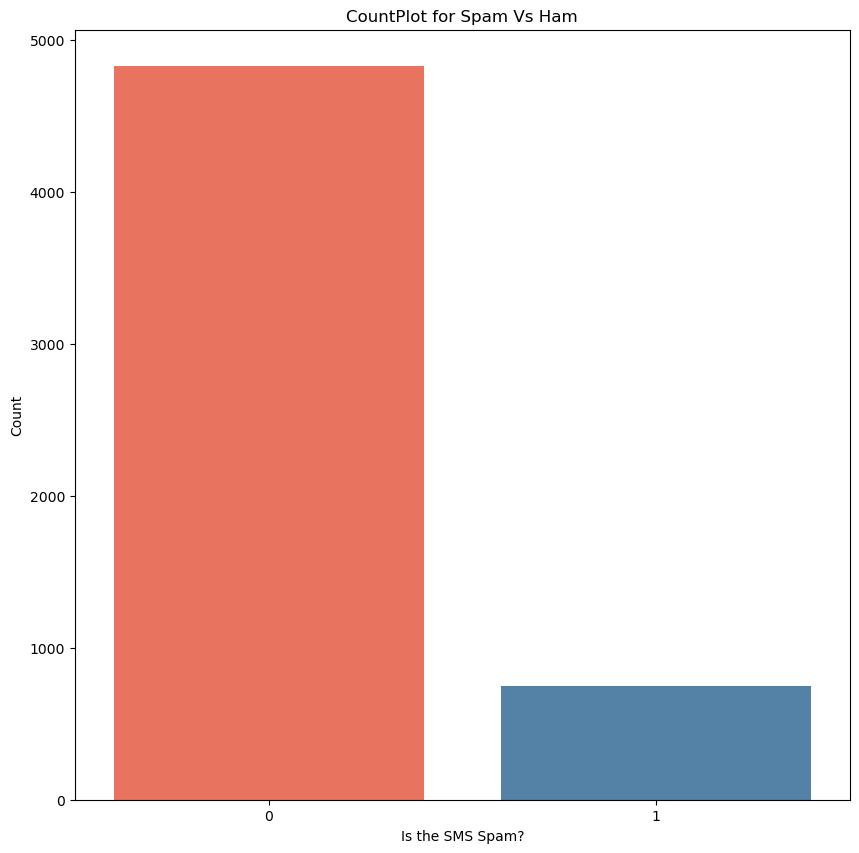

In [2]:
# Load dataset
dataset = pd.read_csv("SMSSpamCollection", sep='\t', names=['label', 'MSG'])

# Mapping labels to binary values
dataset['label'] = dataset['label'].map({"Ham": 0, "Spam": 1})

# Visualization of Spam vs Ham count
plt.figure(figsize=(10,10))
sns.countplot(x="label", palette=["#FF6347", "#4682B4"], data=dataset)
plt.title("CountPlot for Spam Vs Ham")
plt.xlabel("Is the SMS Spam?")
plt.ylabel("Count")
plt.show()


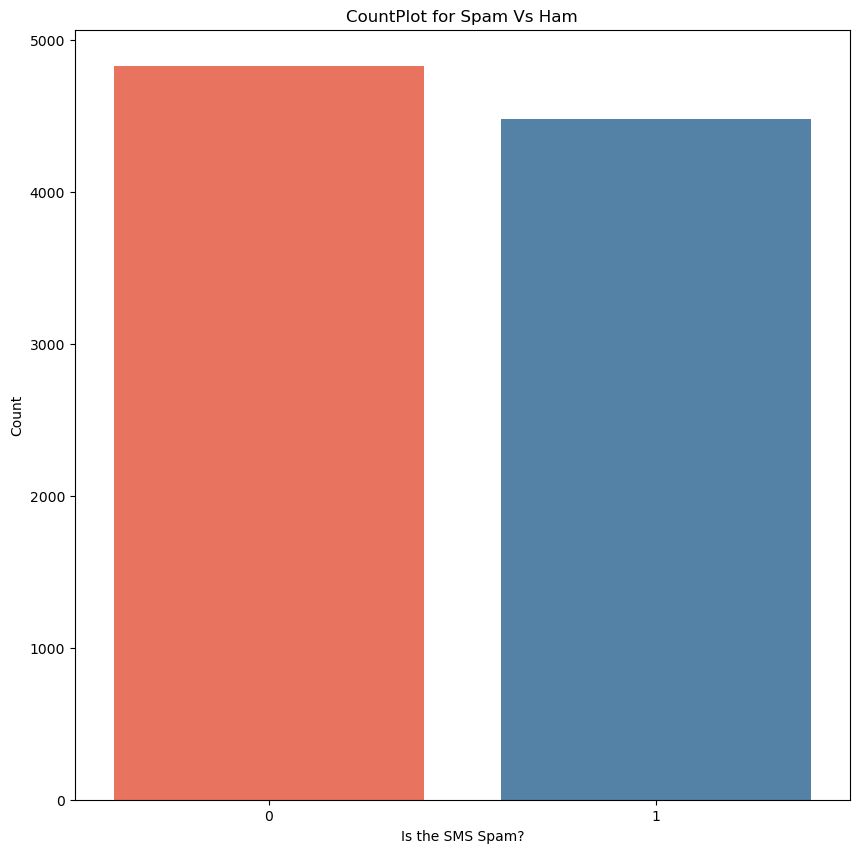

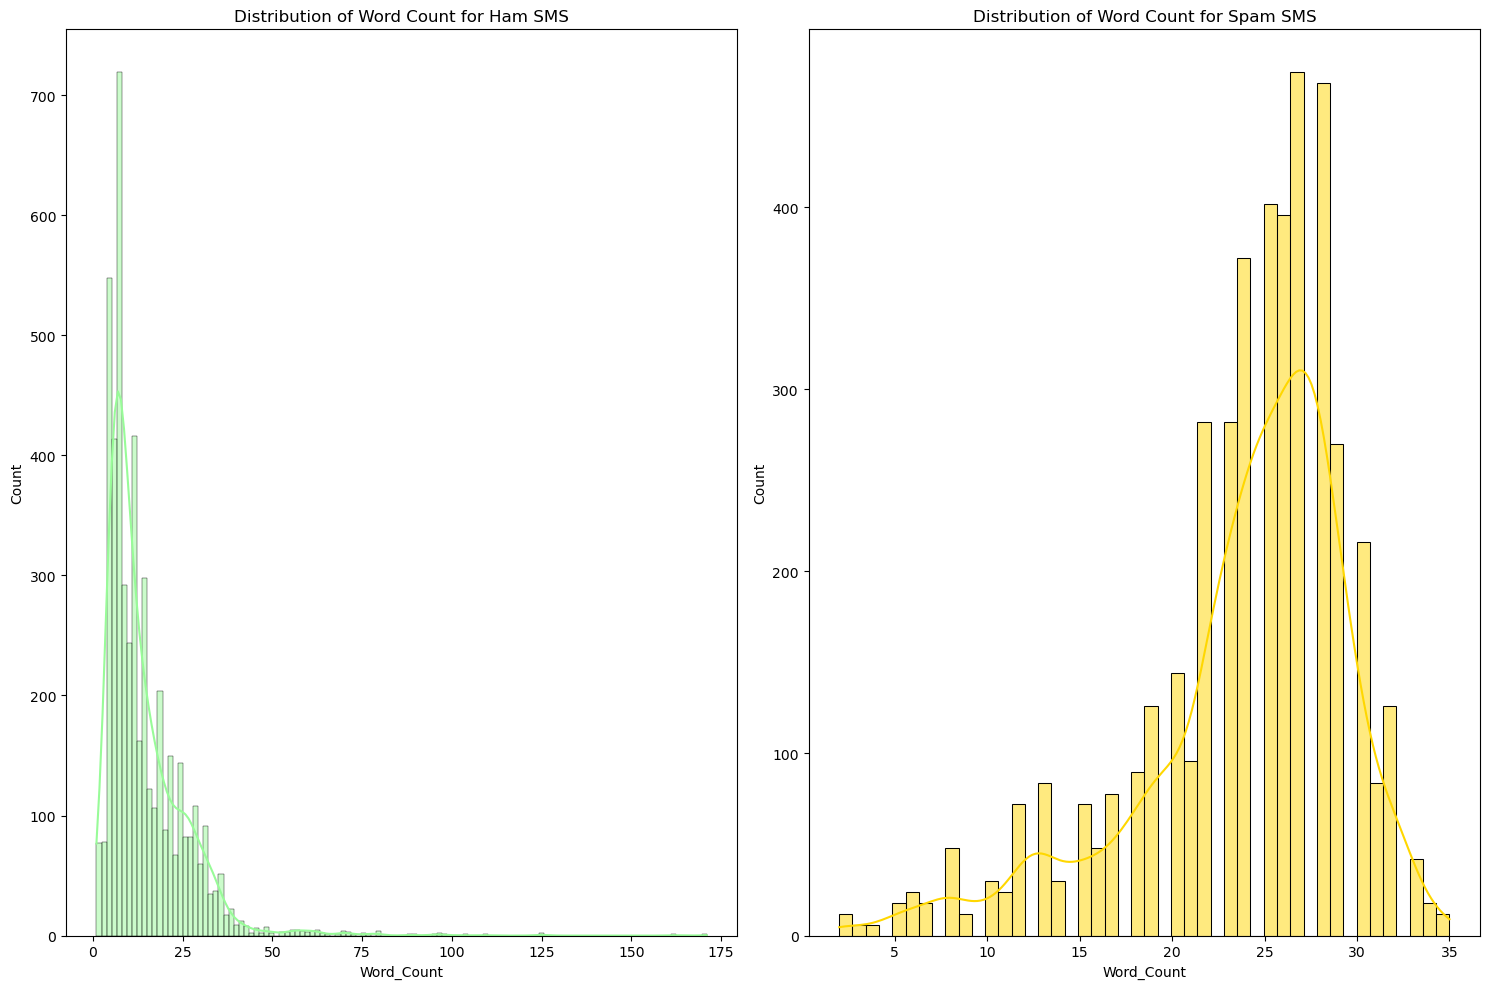

In [3]:

# Handling imbalanced dataset by oversampling Spam messages
Only_Spam = dataset[dataset['label'] == 1]
Count = (dataset.shape[0] - Only_Spam.shape[0]) // Only_Spam.shape[0]
for _ in range(Count - 1):
    dataset = pd.concat([dataset, Only_Spam])

# Visualization after balancing the dataset
plt.figure(figsize=(10,10))
sns.countplot(x="label", palette=["#FF6347", "#4682B4"], data=dataset)
plt.title("CountPlot for Spam Vs Ham")
plt.xlabel("Is the SMS Spam?")
plt.ylabel("Count")
plt.show()

# Creating new feature: Word Count
dataset['Word_Count'] = dataset['MSG'].apply(lambda x: len(x.split()))

# Visualizing Word Count distribution for Ham and Spam
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
sns.histplot(dataset[dataset['label'] == 0].Word_Count, color="#98FB98", kde=True)
plt.title("Distribution of Word Count for Ham SMS")

plt.subplot(1, 2, 2)
sns.histplot(dataset[dataset['label'] == 1].Word_Count, color="#FFD700", kde=True)
plt.title("Distribution of Word Count for Spam SMS")

plt.tight_layout()
plt.show()

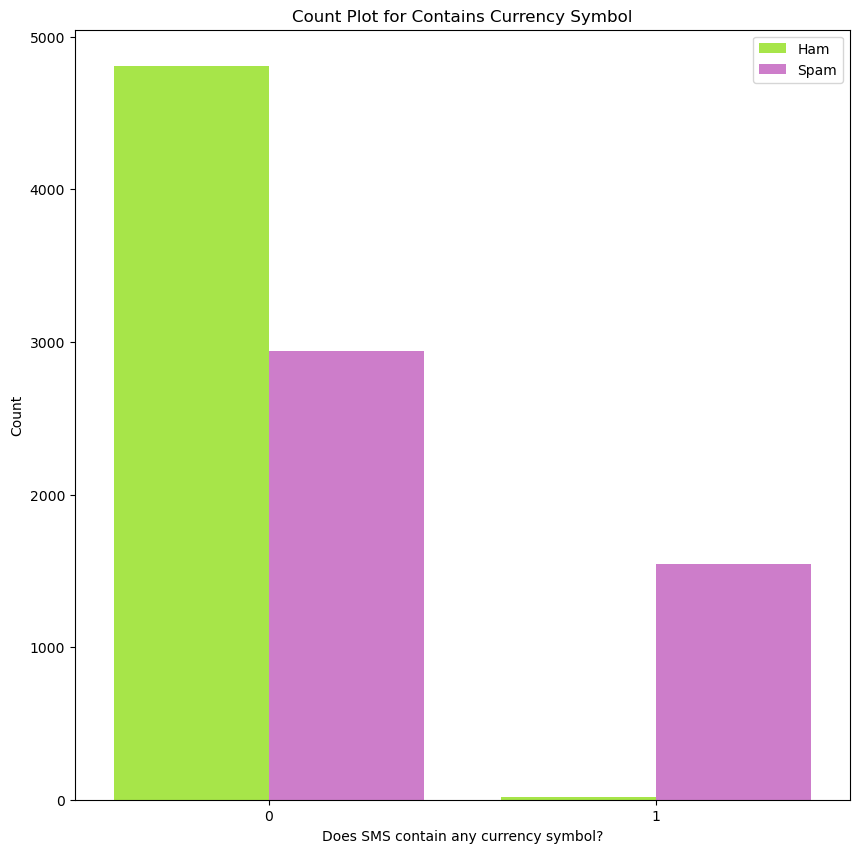

In [4]:
# Creating new feature: Contains_CurrencySymbol
def currency_present(data):
    currency_symbols = {'$', '€', '£', '₹', '¥', '₱', '₩', '₦', '₺', '₫', '₭'}
    return 1 if any(symbol in data for symbol in currency_symbols) else 0

dataset['Contains_CurrencySymbol'] = dataset['MSG'].apply(currency_present)

# Plotting Count Plot for Contains_CurrencySymbol
plt.figure(figsize=(10,10))
sns.countplot(x='Contains_CurrencySymbol', palette=["#ADFF2F", "#DA70D6"], data=dataset, hue='label')
plt.title("Count Plot for Contains Currency Symbol")
plt.xlabel("Does SMS contain any currency symbol?")
plt.ylabel("Count")
plt.legend(labels=["Ham", "Spam"])
plt.show()

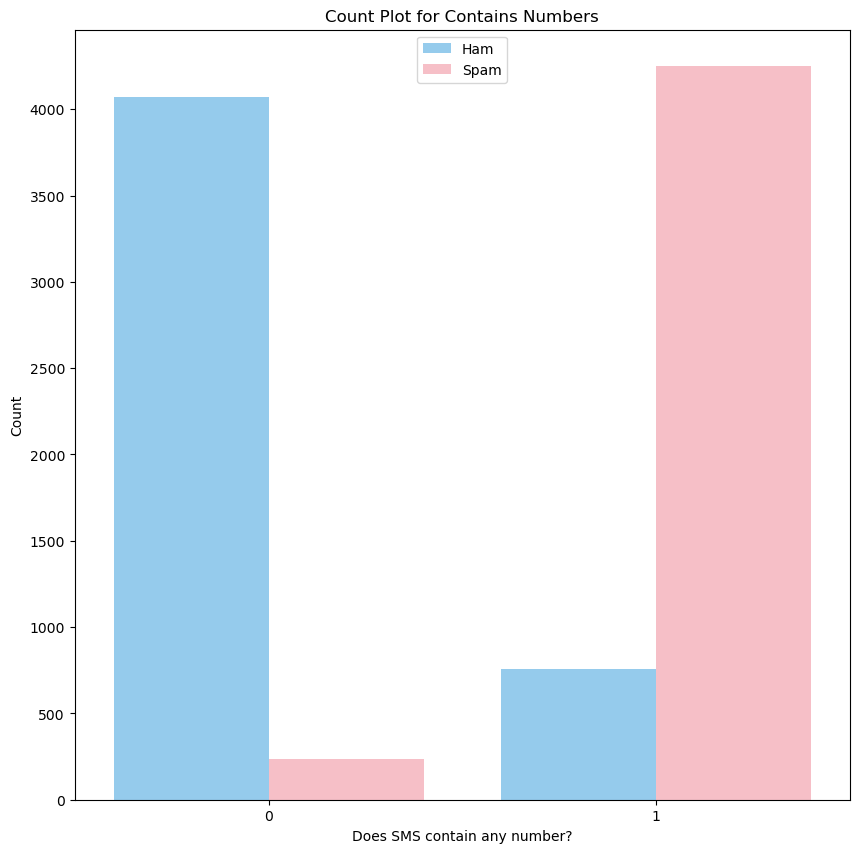

In [5]:
# Creating new feature: Contains_Numbers
def contains_number(data):
    return 1 if any(char.isdigit() for char in data) else 0

dataset["Contains_Numbers"] = dataset["MSG"].apply(contains_number)

# Plotting Count Plot for Contains_Numbers
plt.figure(figsize=(10,10))
sns.countplot(x='Contains_Numbers', data=dataset, palette=["#87CEFA", "#FFB6C1"], hue='label')
plt.title("Count Plot for Contains Numbers")
plt.xlabel("Does SMS contain any number?")
plt.ylabel("Count")
plt.legend(labels=["Ham", "Spam"], loc='upper center')
plt.show()


In [6]:
# Data Cleaning and Preparation for Modeling
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shaik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shaik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:

corpus = []
WordNetLem = WordNetLemmatizer()

for sms in dataset.MSG:
    MSG = re.sub("[^a-zA-Z]", ' ', sms)  # Remove special characters and numbers
    MSG = MSG.lower().split()
    MSG = [WordNetLem.lemmatize(word) for word in MSG if word not in stopwords.words("english")]
    corpus.append(" ".join(MSG))


In [8]:

# Output the processed data
corpus[:5]  # Display the first 5 cleaned SMS messages


['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though']

In [11]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus).toarray()

# The labels are already encoded: Ham = 0, Spam = 1
y = dataset['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Randomly select a new SMS from the dataset
random_index = random.randint(0, len(dataset) - 1)
new_sms = dataset.iloc[random_index]["MSG"]
print(f"Randomly selected SMS: {new_sms}")

# Process the selected SMS the same way we processed the training data
def preprocess_sms(sms):
    WordNetLem = WordNetLemmatizer()
    sms = re.sub("[^a-zA-Z]", ' ', sms)  # Remove special characters and numbers
    sms = sms.lower().split()
    sms = [WordNetLem.lemmatize(word) for word in sms if word not in stopwords.words("english")]
    return " ".join(sms)

new_sms_processed = vectorizer.transform([preprocess_sms(new_sms)]).toarray()

# Predict whether the SMS is spam or ham
prediction = model.predict(new_sms_processed)

if prediction[0] == 1:
    print("This is a Spam message.")
else:
    print("This is a Ham message.")

Accuracy: 98.01%
Confusion Matrix:
 [[936  23]
 [ 14 889]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       959
           1       0.97      0.98      0.98       903

    accuracy                           0.98      1862
   macro avg       0.98      0.98      0.98      1862
weighted avg       0.98      0.98      0.98      1862

Randomly selected SMS: K go and sleep well. Take rest:-).
This is a Ham message.
